In [2]:
import pandas as pd
import langid
import warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('spam.csv',encoding='latin1')
df['v1'] = df['v1'].replace({'ham': 'not_spam'})#, 'spam': 'fraud'})

In [3]:
df=df[['v1','v2']]
new_experiment = {'v1': 'spam', 'v2': 'abcdefghijklmnopqrstuvwxyz'}
df = df.append(new_experiment, ignore_index=True)
df.head()

,v1,v2
0,not_spam,"Go until jurong point, crazy.. Available only ..."
1,not_spam,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,not_spam,U dun say so early hor... U c already then say...
4,not_spam,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
def is_english(text):
    lang, _ = langid.classify(text)
    return lang == 'en'

for index, row in df.iterrows():
    if not is_english(row['v2']):
        df.at[index, 'v1'] = 'spam'

In [5]:
df['v1'].value_counts()

not_spam    4500
spam        1073
Name: v1, dtype: int64

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Preprocess the text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['v2'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['v1'], test_size=0.2, random_state=42)

# Build a logistic regression model
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# You can also print more detailed classification metrics
print(classification_report(y_test, predictions))


Accuracy: 0.92
              precision    recall  f1-score   support

    not_spam       0.92      0.98      0.95       877
        spam       0.92      0.70      0.79       238

    accuracy                           0.92      1115
   macro avg       0.92      0.84      0.87      1115
weighted avg       0.92      0.92      0.92      1115



In [7]:
import pickle
data={'model':model,'vectorizer':vectorizer}
with open ('saved_steps.pkl','wb') as file:
  pickle.dump(data,file)

In [8]:
with open ('saved_steps.pkl','rb') as file:
  data=pickle.load(file)

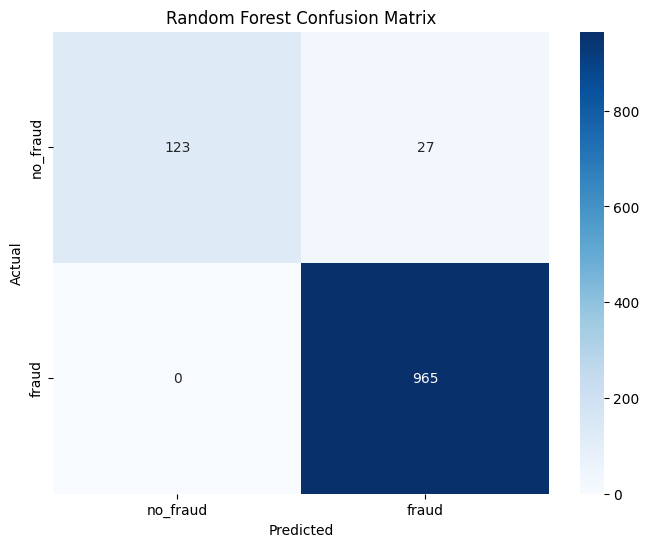


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90       150
           1       0.97      1.00      0.99       965

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



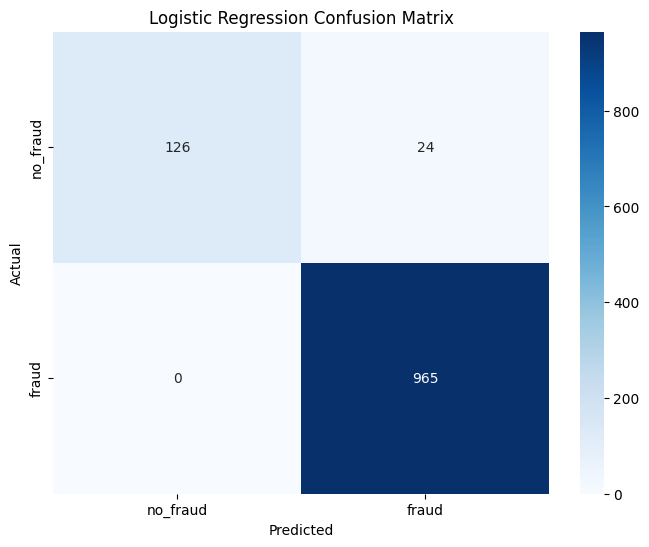


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91       150
           1       0.98      1.00      0.99       965

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

35/35 [==============================] - 0s 3ms/step


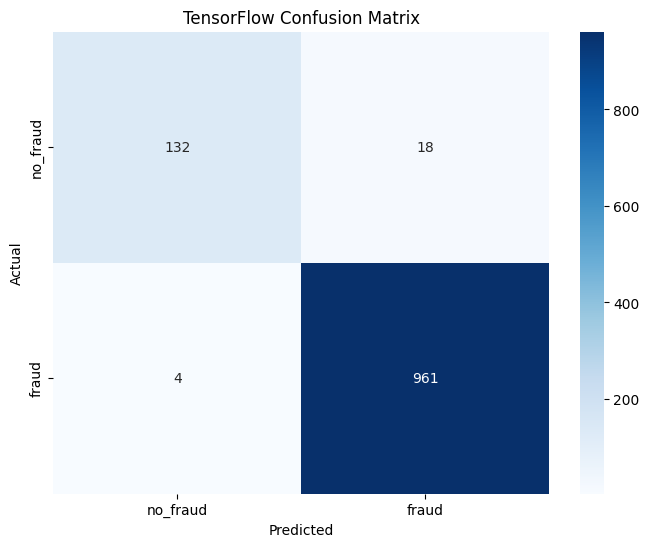


TensorFlow Model Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       150
           1       0.98      1.00      0.99       965

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Encode the 'v1' column (ham/spam) to numerical labels
label_encoder = LabelEncoder()
df['v1'] = label_encoder.fit_transform(df['v1'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['v2'], df['v1'], test_size=0.2, random_state=42)

# Build models using different algorithms

# 1. Random Forest
rf_model = make_pipeline(CountVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Plot Confusion Matrix and Classification Report for Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fraud', 'fraud'], yticklabels=['no_fraud', 'fraud'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# 2. Logistic Regression
lr_model = make_pipeline(CountVectorizer(), LogisticRegression())
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Plot Confusion Matrix and Classification Report for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fraud', 'fraud'], yticklabels=['no_fraud', 'fraud'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))

# 3. TensorFlow Model
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tf_model = Sequential([
    Dense(64, input_shape=(X_train_tfidf.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
])

tf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf_model.fit(X_train_tfidf.toarray(), y_train, epochs=5, batch_size=32, verbose=0)
tf_predictions = (tf_model.predict(X_test_tfidf.toarray()) > 0.5).astype("int32")

# Calculate Confusion Matrix for TensorFlow Model
tf_cm = confusion_matrix(y_test, tf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(tf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fraud', 'fraud'], yticklabels=['no_fraud', 'fraud'])
plt.title("TensorFlow Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nTensorFlow Model Classification Report:\n", classification_report(y_test, tf_predictions))
